In [0]:
# import resources
%matplotlib inline

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
from torchvision import transforms, models

In [0]:
# get the "features" portion of VGG19 (we will not need the "classifier" portion)
vgg = models.vgg19(pretrained=True).features

# freeze all VGG parameters since we're only optimizing the target image
for param in vgg.parameters():
    param.requires_grad_(False)

In [3]:
# move the model to GPU, if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [0]:
def load_image(img_path, max_size=400, shape=None):
    ''' Load in and transform an image, making sure the image
       is <= 400 pixels in the x-y dims.'''
    
    image = Image.open(img_path).convert('RGB')
    
    # large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image

In [0]:
# Resize style to match content, makes code easier
style = load_image('6.jpg').to(device)

In [0]:
def im_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

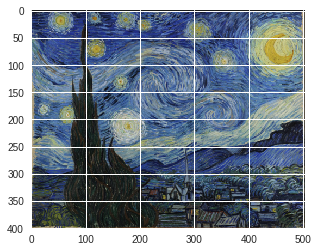

In [7]:
# content and style ims side-by-side
plt.imshow(im_convert(style))

In [0]:
def get_features(image, model, layers=None):
    """ Run an image forward through a model and get the features for 
        a set of layers. Default layers are for VGGNet matching Gatys et al (2016)
    """
    
    ## TODO: Complete mapping layer names of PyTorch's VGGNet to names from the paper
    ## Need the layers for the content and style representations of an image
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',  ## content representation
                  '28': 'conv5_1'}
        
    features = {}
    x = image
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

In [0]:
def gram_matrix(tensor):
    """ Calculate the Gram Matrix of a given tensor 
        Gram Matrix: https://en.wikipedia.org/wiki/Gramian_matrix
    """
    
    # get the batch_size, depth, height, and width of the Tensor
    _, d, h, w = tensor.size()
    
    # reshape so we're multiplying the features for each channel
    tensor = tensor.view(d, h * w)
    
    # calculate the gram matrix
    gram = torch.mm(tensor, tensor.t())
    
    return gram 

In [0]:
# get content and style features only once before training
style_features = get_features(style, vgg)

# calculate the gram matrices for each layer of our style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# create a third "target" image and prep it for change
# it is a good idea to start of with the target as a copy of our *content* image
# then iteratively change its style

In [0]:
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 2  # alpha
style_weight = 1e10  # beta

In [0]:
def convert(tensor):
  image = tensor.to("cpu").clone().detach()
  image = image.numpy().squeeze()
  
  return image

conv1_1
torch.Size([64, 64])
conv2_1
torch.Size([128, 128])
conv3_1
torch.Size([256, 256])
conv4_1
torch.Size([512, 512])
conv5_1
torch.Size([512, 512])


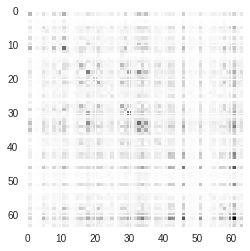

In [13]:
# for displaying the target image, intermittently

# iteration hyperparameters
i = 0
for layer in style_weights:
    print(layer)
    # taking gram matrix *style feature* for layer 
    style_gram = style_grams[layer]
    print(style_gram.shape)
    if i == 0:
      plt.imshow(convert(style_gram))
    i = i + 1

In [0]:
im1 = load_image('PinterestSmall.jpg').to(device)
im2 = load_image('abendgesellschaft-1847(1).jpg!PinterestSmall.jpg').to(device)
im3 = load_image('la-hacienda-buenavista-en-ponce-puerto-rico-1840.jpg!PinterestSmall.jpg').to(device)
im4 = load_image('s.jpg').to(device)
im5 = load_image('s2.jpg').to(device)


imgs = [im1, im2, im3, im4, im5]


In [0]:
grams = []
layer = 'conv1_1'

res = []
for im in imgs:
  lst = []
  style_features = get_features(im, vgg)
  style_gram = gram_matrix(style_features[layer])
  grams.append(style_gram)
  
  for img in imgs:
    style_features = get_features(img, vgg)
    gram = gram_matrix(style_features[layer])
    lst.append(round(np.float(torch.mean((gram - style_gram)**2)), 3))
  
  res.append(lst)
res = np.asarray(res).reshape(5,5)
 #torch.mean((get_features(img, vgg)['conv1_1'] - style_gram)**2)

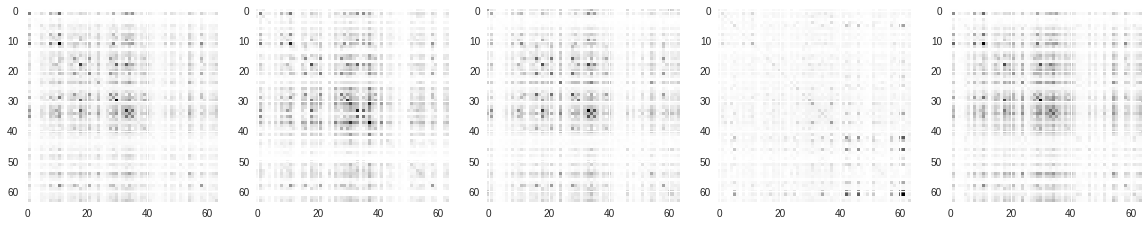

In [82]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(convert(grams[0]))
ax2.imshow(convert(grams[1]))
ax3.imshow(convert(grams[2]))
ax4.imshow(convert(grams[3]))
ax5.imshow(convert(grams[4]))

In [83]:
g = np.asarray(grams[0].to('cpu'))
g.shape

(64, 64)

In [84]:
from sklearn.decomposition import PCA

ipca = PCA(0.95).fit(g)
img_c = ipca.transform(g)
print(img_c.shape)
print(np.sum(ipca.explained_variance_ratio_))


(64, 3)
0.9686445


(64, 64)


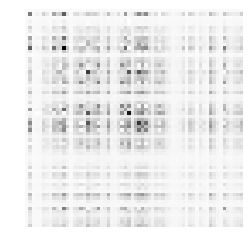

In [85]:
temp = ipca.inverse_transform(img_c)
print(temp.shape)
plt.axis('off')
plt.imshow(temp)

In [86]:
np.mean((temp - convert(grams[0]))**2)

695661.4